In [39]:
# Delete error images
from PIL import Image
import os

root = "worms/"

for folder in os.listdir(root):
    path = os.path.join(root, folder)
    for f in os.listdir(path):
        fp = os.path.join(path, f)
        try:
            img = Image.open(fp)
            img.verify()
            # print("Image passed", fp)
        except:
            print("Image error:", fp)
            os.remove(fp)


In [40]:
import os, shutil, random

source = "worms/"
target = "dataset_split/"

os.makedirs(os.path.join(target, "train"), exist_ok=True)
os.makedirs(os.path.join(target, "val"), exist_ok=True)
os.makedirs(os.path.join(target, "test"), exist_ok=True)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for cls in os.listdir(source):
    cls_path = os.path.join(source, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    n = len(images)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    for subset_name, subset_imgs in zip(
        ["train", "val", "test"], 
        [train_imgs, val_imgs, test_imgs]
    ):
        subset_dir = os.path.join(target, subset_name, cls)
        os.makedirs(subset_dir, exist_ok=True)

        for img in subset_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(subset_dir, img))


In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [42]:
DATASET_DIR = "dataset_split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [43]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    f"{DATASET_DIR}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    f"{DATASET_DIR}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    f"{DATASET_DIR}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 487 images belonging to 4 classes.
Found 290 images belonging to 4 classes.
Found 175 images belonging to 4 classes.


In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 4

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [45]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[callback],
    class_weight={0:1.2,1:1,2:1.2,3:1}
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3892 - loss: 1.5118 - val_accuracy: 0.6793 - val_loss: 1.0155
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.6091 - loss: 1.1372 - val_accuracy: 0.7517 - val_loss: 0.8545
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6762 - loss: 1.0021 - val_accuracy: 0.7966 - val_loss: 0.7675
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7594 - loss: 0.8972 - val_accuracy: 0.8172 - val_loss: 0.7103
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7575 - loss: 0.8923 - val_accuracy: 0.8241 - val_loss: 0.6939
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8085 - loss: 0.8281 - val_accuracy: 0.8552 - val_loss: 0.6857
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 897ms/step - accuracy: 0.8278 - loss: 0.7782 - val_accuracy: 0.8655 - val_loss: 0.6407
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - accuracy: 0.8075 - loss: 0.8137 - val_accuracy: 0.8724 - 

In [46]:
model.save("worms_model.h5")
print("Model saved!")


Model saved!


In [47]:
# Evaluate the trained model
loss, acc = model.evaluate(test_gen)
print("Test Accuracy:", acc)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.8760 - loss: 0.6164
Test Accuracy: 0.9028571248054504


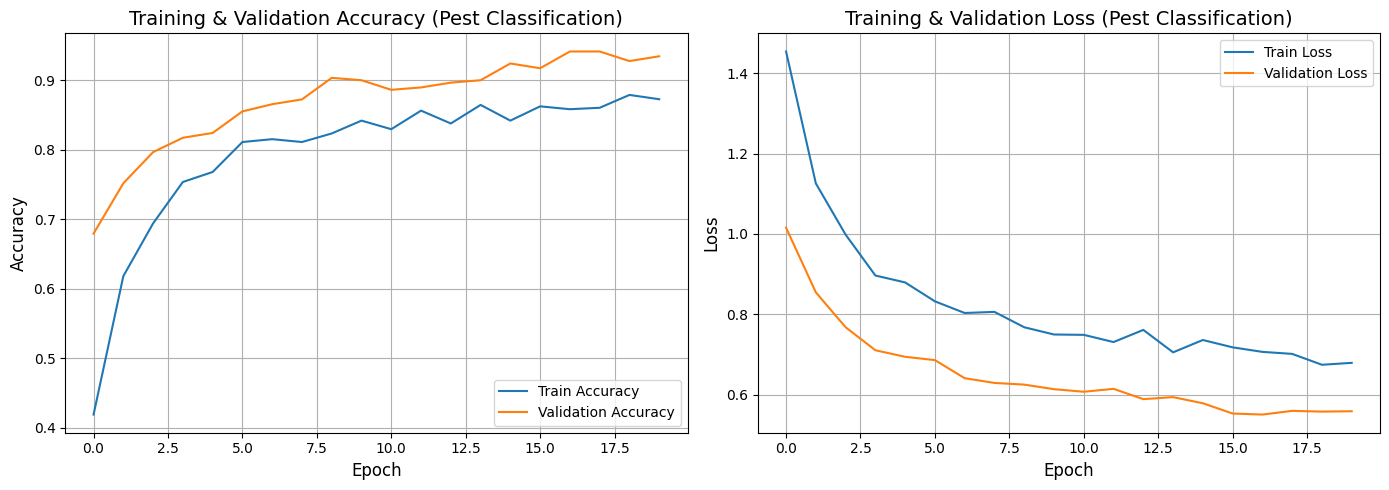

In [48]:
import matplotlib.pyplot as plt

# Visualize training history for pest classification
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy (Pest Classification)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss (Pest Classification)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


Random test image: 22.5361214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


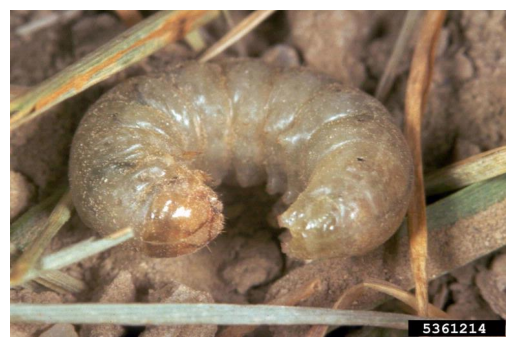

Result: cutworm


In [50]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import random
classes = ["cabbage worm", "corn earworm", "cutworm", "fall armyworm"]

def predict_image(img_path, threshold=0.5):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    confidence = float(predictions[0][class_index])

    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.show()

    if confidence < threshold:
        print(f"Result: Unknown / Not a worm")
    else:
        print(f"Result: {classes[class_index]}")
    
    return predictions


def predict_random_image(folder="test_model"):
    images = [f for f in os.listdir(folder) 
        if os.path.isfile(os.path.join(folder, f)) and f.lower().endswith((".png", ".jpg", ".jpeg"))]

    if not images:
        print("No images found in folder!")
        return

    img_name = random.choice(images)
    img_path = os.path.join(folder, img_name)

    print("Random test image:", img_name)
    predict_image(img_path)


predict_random_image()
